# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [2]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [3]:
pd.set_option('display.max_columns', None)
websites = pd.read_csv('../website.csv')
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,NaN,NaN,10/10/2015 18:21,NaN,7,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,NaN,NaN,NaN,NaN,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,NaN,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [4]:
websites.dtypes

URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

In [5]:
websites.shape

(1781, 21)

In [6]:
"""Which columns contain the features of the websites?
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64

These are the columns with quantitative data data we can use to predict the outcome: malign(1)/benign(0)

"""

'Which columns contain the features of the websites?\nTCP_CONVERSATION_EXCHANGE      int64\nDIST_REMOTE_TCP_PORT           int64\nREMOTE_IPS                     int64\nAPP_BYTES                      int64\nSOURCE_APP_PACKETS             int64\nREMOTE_APP_PACKETS             int64\nSOURCE_APP_BYTES               int64\nREMOTE_APP_BYTES               int64\nAPP_PACKETS                    int64\nDNS_QUERY_TIMES              float64\n\nThese are the columns with quantitative data data we can use to predict the outcome: malign(1)/benign(0)\n\n'

In [7]:
"""
Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
Column: Type gives the final answer we're looking for
1 - Malign (!alert!) was flagged as 1 for being bad that's what we're trying to spot
0 - Benign
"""

"\nWhich column contains the feature we will predict? What is the code standing for benign vs malicious websites?\nColumn: Type gives the final answer we're looking for\n1 - Malign (!alert!) was flagged as 1 for being bad that's what we're trying to spot\n0 - Benign\n"

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [11]:
# Creating the correlation matrix:
numeric_columns_to_correlate = ["TCP_CONVERSATION_EXCHANGE","DIST_REMOTE_TCP_PORT","REMOTE_IPS","APP_BYTES","SOURCE_APP_PACKETS","REMOTE_APP_PACKETS","APP_PACKETS","DNS_QUERY_TIMES"]
correlation_websites_numeric_columns = websites[numeric_columns_to_correlate].corr()
correlation_websites_numeric_columns

,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,APP_PACKETS,DNS_QUERY_TIMES
TCP_CONVERSATION_EXCHANGE,1.000000,0.555188,0.331080,0.457320,0.997796,0.990848,0.997796,0.349832
DIST_REMOTE_TCP_PORT,0.555188,1.000000,0.210188,0.780238,0.558612,0.591188,0.558612,0.259942
REMOTE_IPS,0.331080,0.210188,1.000000,0.023126,0.361104,0.304683,0.361104,0.548189
APP_BYTES,0.457320,0.780238,0.023126,1.000000,0.445822,0.468999,0.445822,0.012221
SOURCE_APP_PACKETS,0.997796,0.558612,0.361104,0.445822,1.000000,0.989285,1.000000,0.410843
REMOTE_APP_PACKETS,0.990848,0.591188,0.304683,0.468999,0.989285,1.000000,0.989285,0.355716
APP_PACKETS,0.997796,0.558612,0.361104,0.445822,1.000000,0.989285,1.000000,0.410843
DNS_QUERY_TIMES,0.349832,0.259942,0.548189,0.012221,0.410843,0.355716,0.410843,1.000000


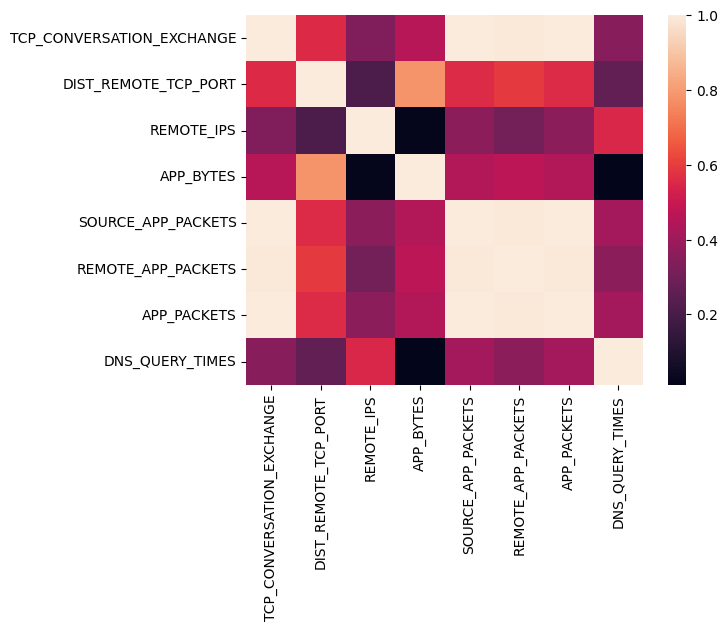

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_websites_numeric_columns);

In [ ]:
#Comment on which columns you might need to remove due to high collinearity.
"""
The lighter shades in the heatmap indicate a higher correlation between variables 
(we can easily confirm this because the diagonal should entail a perfect correlation (1) between the variable and itself).

We see TCP_CONVERSATION_EXCHANGE having a high correlation with Packets (SOURCE_APP_PACKETS, REMOTE_APP_PACKETS and APP_PACKETS):
respectively: 0.997796 / 0.990848 / 0.997796

this is incredibly high and might lead to collinearity.

Also the packets between themselves, for example: SOURCE_APP_PACKETS correlates
0.989285 with REMOTE_APP_PACKETS 
and
1.000000 with APP_PACKETS
"""

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [ ]:
#to keep the code simpler, let's say we do it in 2 instances:
"""
numeric_columns_to_correlate1: we remove SOURCE_APP_PACKETS
numeric_columns_to_correlate2: we remove REMOTE_APP_PACKETS
"""

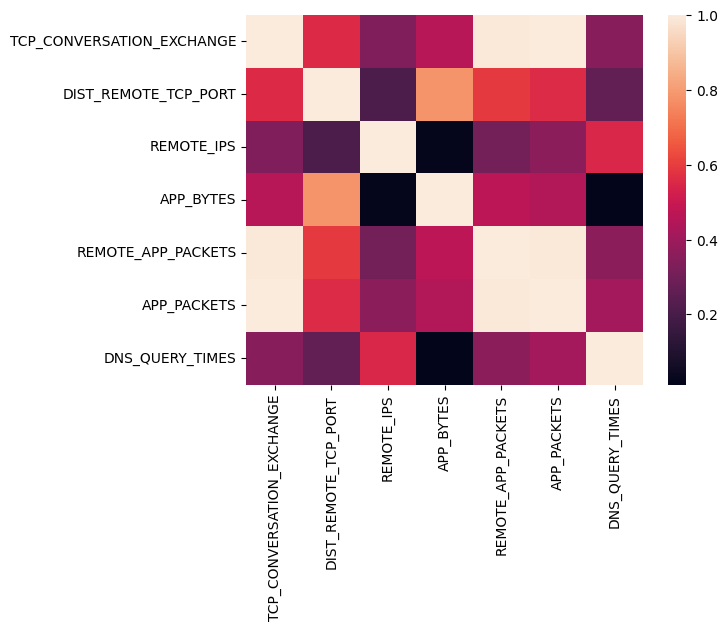

In [13]:
numeric_columns_to_correlate1 = ["TCP_CONVERSATION_EXCHANGE","DIST_REMOTE_TCP_PORT","REMOTE_IPS","APP_BYTES","REMOTE_APP_PACKETS","APP_PACKETS","DNS_QUERY_TIMES"]
correlation_websites_numeric_columns1 = websites[numeric_columns_to_correlate1].corr()
sns.heatmap(correlation_websites_numeric_columns1);

In [ ]:
#still high correl between the apps, let's remove more!

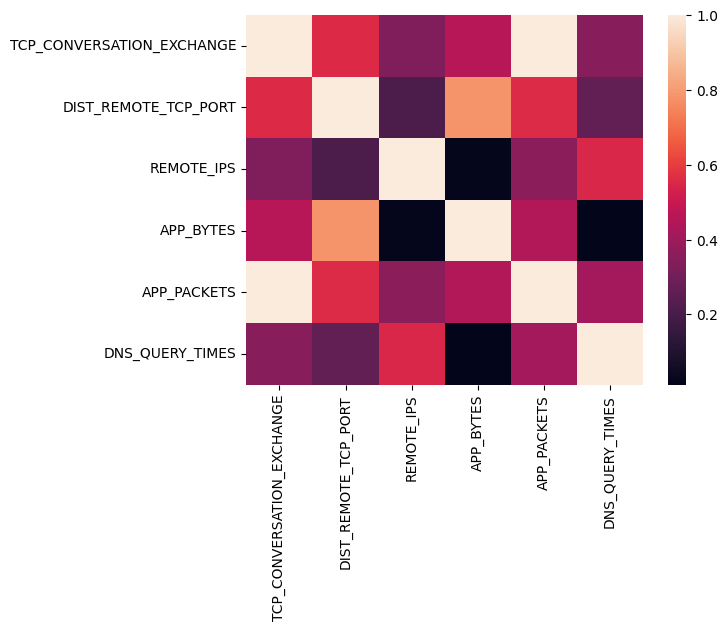

In [14]:
numeric_columns_to_correlate2 = ["TCP_CONVERSATION_EXCHANGE","DIST_REMOTE_TCP_PORT","REMOTE_IPS","APP_BYTES","APP_PACKETS","DNS_QUERY_TIMES"]
correlation_websites_numeric_columns2 = websites[numeric_columns_to_correlate2].corr()
sns.heatmap(correlation_websites_numeric_columns2);

In [ ]:
#no more collinearity problems apparently!

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [15]:
websites.isna().sum()

URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        7
SERVER                       176
CONTENT_LENGTH               812
WHOIS_COUNTRY                306
WHOIS_STATEPRO               362
WHOIS_REGDATE                127
WHOIS_UPDATED_DATE           139
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [24]:
percentages_of_missing_values = pd.DataFrame(websites.isna().sum())
percentages_of_missing_values.columns = ['Missing values']
percentages_of_missing_values["% missing values"] = percentages_of_missing_values["Missing values"] / 1781
percentages_of_missing_values

,Missing values,% missing values
URL,0,0.000000
URL_LENGTH,0,0.000000
NUMBER_SPECIAL_CHARACTERS,0,0.000000
CHARSET,7,0.003930
SERVER,176,0.098821
CONTENT_LENGTH,812,0.455924
WHOIS_COUNTRY,306,0.171814
WHOIS_STATEPRO,362,0.203257
WHOIS_REGDATE,127,0.071308
WHOIS_UPDATED_DATE,139,0.078046


In [35]:
#I'm going to drop content_lenght cause of the hi percentage of missing values and then remove the rows wuere the missing values for the columns is higher than 1%
websites_cleaned = websites.drop(["CONTENT_LENGTH"], axis=1)
websites_cleaned.sample(5)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
294,B0_2156,35,7,UTF-8,Sucuri/Cloudproxy,CA,ON,17/07/2009 0:00,7/07/2016 0:00,8,6,6,696,8,5,306,696,8,0.0,0
1229,B0_342,61,13,UTF-8,cloudflare-nginx,US,WA,3/04/2011 0:00,11/03/2017 0:00,31,5,8,4514,39,40,26105,5168,39,8.0,0
1357,B0_58,69,11,utf-8,Apache,NaN,NaN,1/06/2006 0:00,6/03/2017 0:00,23,15,10,2708,27,30,6195,3036,27,4.0,0
1581,B0_960,90,16,UTF-8,ebay server,US,CA,4/08/1995 0:00,26/01/2017 0:00,0,0,0,0,0,0,0,0,0,0.0,0
1171,B0_426,59,13,ISO-8859-1,nginx/1.4.4,US,UT,21/06/1997 0:00,21/10/2016 0:00,8,3,8,552,8,5,420,552,8,0.0,0


In [45]:
#now dropping the rows with NANs

websites_cleaned = websites_cleaned[websites_cleaned['SERVER'].notna()]
websites_cleaned = websites_cleaned[websites_cleaned['WHOIS_COUNTRY'].notna()]
websites_cleaned = websites_cleaned[websites_cleaned['WHOIS_STATEPRO'].notna()]
websites_cleaned = websites_cleaned[websites_cleaned['WHOIS_REGDATE'].notna()]
websites_cleaned = websites_cleaned[websites_cleaned['WHOIS_UPDATED_DATE'].notna()]


print(f"new shape of the cleaned websites DF is:{websites_cleaned.shape}")

new shape of the cleaned websites DF is:(1264, 20)


#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [46]:
websites_cleaned.isna().sum()

URL                          0
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      6
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              1
Type                         0
dtype: int64

In [47]:
#yeah, I'm happy with this.

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [64]:
#1.
websites_cleaned['WHOIS_COUNTRY'].unique()

#2. capitalize letters
websites_cleaned['WHOIS_COUNTRY'] = websites_cleaned['WHOIS_COUNTRY'].str.upper()

#2.1 consolidate
websites_cleaned['WHOIS_COUNTRY'] = websites_cleaned['WHOIS_COUNTRY'].replace('UK', 'GB')
websites_cleaned['WHOIS_COUNTRY'] = websites_cleaned['WHOIS_COUNTRY'].apply(lambda x: 'GB' if 'GB' in x or 'UK' in x else x)

# Check unique values after consolidation
print(f"Unique values for WHOIS_COUNTRY = {websites_cleaned['WHOIS_COUNTRY'].unique()}")


Unique values for WHOIS_COUNTRY = ['US' 'SC' 'RU' 'AU' 'CA' 'PA' 'IN' 'GB' 'NL' 'UG' 'JP' 'CN' 'SI' 'KY'
 'AT' 'CZ' 'PH' 'LV' 'TR' 'ES' 'HK' 'UA' 'CH' 'BS' 'PK' 'IL' 'DE' 'SE'
 'IT' 'NO' 'BE' 'BY' 'AE' 'IE' 'UY' 'KG']


Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

<Axes: xlabel='WHOIS_COUNTRY', ylabel='count'>

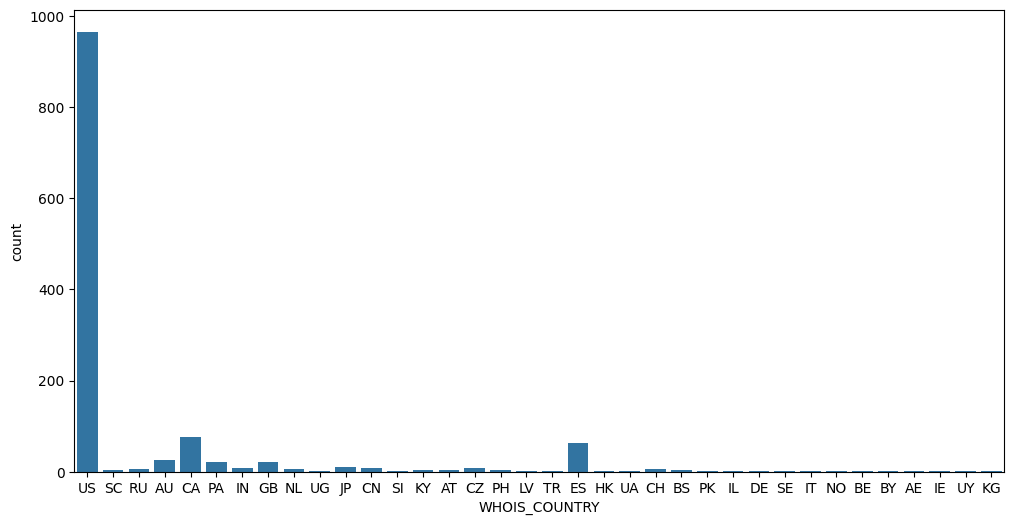

In [68]:
plt.figure(figsize=(12, 6))
sns.countplot(x='WHOIS_COUNTRY', data=websites_cleaned)

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [71]:
websites_cleaned['WHOIS_COUNTRY'].value_counts()[:10].index.tolist()

['US', 'CA', 'ES', 'AU', 'GB', 'PA', 'JP', 'CN', 'IN', 'CZ']

In [77]:
top_10_countries = websites_cleaned['WHOIS_COUNTRY'].value_counts()[:10].index.tolist()

websites_cleaned.loc[~websites_cleaned['WHOIS_COUNTRY'].isin(top_10_countries), 'WHOIS_COUNTRY'] = 'other'

#checking again:
websites_cleaned["WHOIS_COUNTRY"].unique()

array(['US', 'other', 'AU', 'CA', 'PA', 'IN', 'GB', 'JP', 'CN', 'ES'],
      dtype=object)

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [82]:
# websites_cleaned = websites_cleaned.drop(columns=['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'],axis=1)
websites_cleaned.sample(5)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,WHOIS_COUNTRY,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
862,B0_1123,49,9,us-ascii,Microsoft-HTTPAPI/2.0,US,0,0,0,0,0,0,0,0,0,0.0,0
95,M0_75,27,7,UTF-8,Apache,US,9,0,1,1838,11,13,4524,1992,11,2.0,1
1628,M4_12,100,20,UTF-8,Apache,ES,0,0,0,0,0,3,186,0,0,0.0,1
1743,M4_46,135,26,UTF-8,Apache,ES,0,0,0,0,0,3,186,0,0,0.0,1
689,B0_633,44,9,iso-8859-1,barista/5.1.3,US,10,0,5,1197,14,15,1424,1503,14,4.0,0


# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [83]:
websites_cleaned.dtypes

URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
WHOIS_COUNTRY                 object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [88]:
#websites_cleaned = websites_cleaned.drop(["URL"],axis=1)
websites_cleaned.sample(5)

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,WHOIS_COUNTRY,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
74,26,7,ISO-8859-1,Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_b...,GB,7,0,2,722,11,9,1913,1036,11,4.0,1
188,31,7,utf-8,Apache,US,0,0,0,0,0,0,0,0,0,0.0,0
612,42,7,utf-8,openresty/1.11.2.1,US,19,15,3,2864,23,26,10465,3168,23,4.0,0
1305,66,12,UTF-8,Server,US,0,0,0,0,0,0,0,0,0,0.0,0
1044,55,10,UTF-8,mw2164.codfw.wmnet,US,0,0,0,0,0,0,0,0,0,0.0,0


#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [89]:
websites_cleaned["CHARSET"].unique()

array(['ISO-8859-1', 'UTF-8', 'iso-8859-1', 'us-ascii', 'utf-8', nan,
       'windows-1251', 'windows-1252'], dtype=object)

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [90]:
websites_cleaned["SERVER"].unique()

array(['nginx', 'Apache/2', 'Microsoft-HTTPAPI/2.0', 'Apache',
       'openresty/1.11.2.1', 'Apache/2.4.7 (Ubuntu)', 'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'cloudflare-nginx', 'Apache/2.2.22', 'nginx/1.8.0',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'tsa_c', 'Apache/2.2.22 (Debian)', 'Apache/2.2.15 (CentOS)',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Pepyaka/1.11.3', 'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips',
       'Apache/2.2.22 (Ubuntu)', 'Apache/2.4.25', 'Tengine',
       'Apache/2.4.18 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.6 (CentOS) PHP/5.6.8',
       'Apache/2.4.18 (Unix) OpenSSL/1.0.2e Communique/4.1.10',
       'AmazonS3',
       'Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1',
       'ATS'

![Think Hard](../think-hard.jpg)

In [91]:
"""
I see Apache and mw_ _ _ _ and some others repeated, maybe we could use a RegEx to extrapolate these and make "other" with the remaining values?
"""

'\nI see Apache and mw_ _ _ _ and some others repeated, maybe we could use a RegEx to extrapolate these and make "other" with the remaining values?\n'

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [93]:
#There you go! The major ones. OK.      Microsoft, Apache, nginx

def rename_server(server):
    if "Microsoft" in server:
        return "Microsoft"
    elif "Apache" in server:
        return "Apache"
    elif "nginx" in server:
        return "nginx"
    else: 
        return "other"

    
websites_cleaned["SERVER"] = websites_cleaned["SERVER"].apply(rename_server)

In [101]:
websites_cleaned["SERVER"].value_counts()

SERVER
Apache       494
nginx        322
other        302
Microsoft    146
Name: count, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [103]:
columns_to_encode = ['CHARSET', 'SERVER', 'WHOIS_COUNTRY']

website_dummy = pd.get_dummies(websites_cleaned, columns=columns_to_encode, drop_first=True)


Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [107]:
#website_dummy
website_dummy.dtypes
website_dummy = website_dummy.fillna(0).astype(int)
website_dummy

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_Microsoft,SERVER_nginx,SERVER_other,WHOIS_COUNTRY_CA,WHOIS_COUNTRY_CN,WHOIS_COUNTRY_ES,WHOIS_COUNTRY_GB,WHOIS_COUNTRY_IN,WHOIS_COUNTRY_JP,WHOIS_COUNTRY_PA,WHOIS_COUNTRY_US,WHOIS_COUNTRY_other
3,17,6,31,22,3,3812,39,37,18784,4380,39,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
5,18,7,11,6,9,894,11,13,838,894,11,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
6,18,6,12,0,3,1189,14,13,8559,1327,14,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,19,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
10,20,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,194,16,0,0,0,0,0,3,186,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1777,198,17,0,0,0,0,0,2,124,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1778,201,34,83,2,6,6631,87,89,132181,6945,87,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1779,234,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [111]:
from sklearn.model_selection import train_test_split

# Your code here:
X = website_dummy.drop(["Type"],axis=1)
y = website_dummy["Type"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [113]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr

LogisticRegression()

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [119]:
lr.fit(X, y)
y_pred = lr.predict(X_test)
y_pred

C:\Users\mocid\miniconda3\envs\ironhack_5\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
confusion_matrix(y_pred, y_test)

array([[225,  28],
       [  0,   0]], dtype=int64)

What are your thoughts on the performance of the model? Write your conclusions below.

In [4]:
"""
the model generated 225 bullseye True Negative, meaning:
225 values should be benign websites and the model predicted them correctly

However, in 28 instances the model predicted these were malign when indeed they were benign, false positives 
"""

#### Our second algorithm is is DecisionTreeClassifier

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `DecisionTreeClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where max_depth=3

In [147]:
from sklearn.tree import DecisionTreeClassifier
decisiontreeclssf = DecisionTreeClassifier(max_depth=3)
decisiontreeclssf

DecisionTreeClassifier(max_depth=3)

In [148]:
decisiontreeclssf.fit(X,y)

DecisionTreeClassifier(max_depth=3)

In [149]:
y_pred_decisiontree = decisiontreeclssf.predict(X_test)
y_pred_decisiontree

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

To test your model, compute the predicted probabilities, decide 0 or 1 using a threshold of 0.5 and print the confusion matrix as well as the accuracy score (on the test set!)

In [151]:
predicted_probability = decisiontreeclssf.predict_proba(X_test)
#print(predicted_probability)

threshold = 0.5
binary_predictions = (predicted_probability[:, 1] > threshold).astype(int)
#print(binary_predictions)

print(f"accuracy score is: {accuracy_score(y_test, y_pred_decisiontree)}")
confusion_matrix(y_pred_decisiontree, y_test)

accuracy score is: 0.9525691699604744


array([[225,  12],
       [  0,  16]], dtype=int64)

In [ ]:
#comments:
"""
the model reduced the occasions it got values wrong from 28 to 12 (false positives) and this time also got bullseye 
16 true positives (values where he website was indeed fraudulent and the model correctly predicted it!)
"""

#### We'll create another DecisionTreeClassifier model with max_depth=5. 
Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [142]:
decisiontreeclssf_depth5 = DecisionTreeClassifier(max_depth=5)
decisiontreeclssf_depth5

DecisionTreeClassifier(max_depth=5)

In [145]:
decisiontreeclssf_depth5.fit(X,y)

DecisionTreeClassifier(max_depth=5)

In [152]:
y_pred_decisiontree5 = decisiontreeclssf_depth5.predict(X_test)
print(f"accuracy score is: {accuracy_score(y_test, y_pred_decisiontree5)}")
confusion_matrix(y_pred_decisiontree5, y_test)

accuracy score is: 0.9604743083003953


array([[224,   9],
       [  1,  19]], dtype=int64)

Did you see an improvement in the confusion matrix when increasing max_depth to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [153]:
#comments:
"""
yes! viva la model! the accuracy increaced from 95% to 97% and this time the model only made wrong (false) 
predictions on 10 occasions (1 false negative, meaning it predicted it to be a benign website that was actually malign)
and 9 false positives (flagged when the site was legit)
"""

'\nyes! viva la model! the accuracy increaced from 95% to 97% and this time the model only made wrong (false) predictions on 10 occasions\n'

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [ ]:
# Your code here